In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

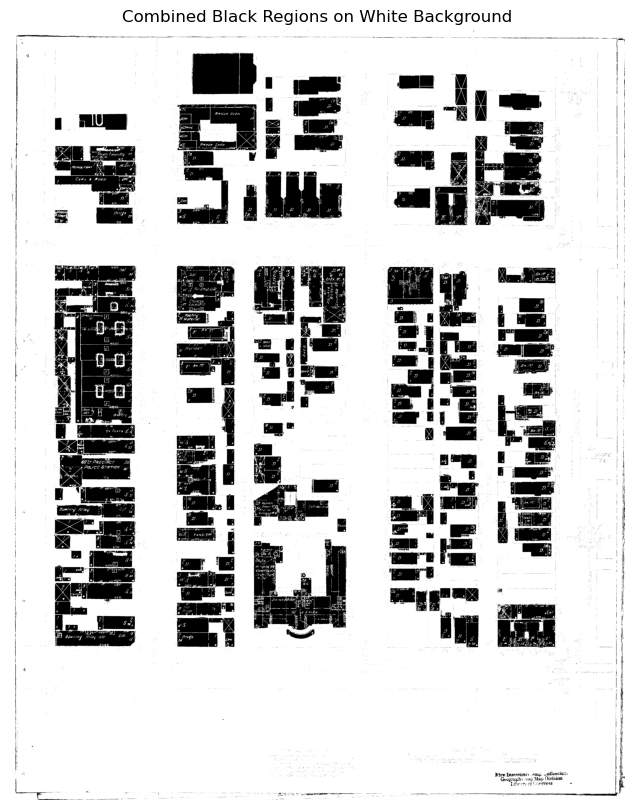

Result image saved at: combined_black_regions_cv2_1.png


In [8]:
def extract_and_display_colored_regions(image_path):
    """
    Extract yellow and pink regions from an image and display these regions on a white background.
    
    Parameters:
    image_path (str): The path to the image file
    """
    # Read the image
    image = cv2.imread(image_path)

    # Check if the image is loaded correctly
    if image is None:
        raise ValueError("Image not found or unable to load.")

    # Convert to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color ranges
    # Yellow range
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Pink range
    lower_pink = np.array([0, 40, 60])
    upper_pink = np.array([15, 255, 255])

    # Create masks to extract yellow and pink regions
    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    pink_mask = cv2.inRange(hsv_image, lower_pink, upper_pink)

    # Combine the masks for yellow and pink regions
    combined_mask = cv2.bitwise_or(yellow_mask, pink_mask)

    # Create a white background
    white_background = np.ones_like(image) * 255

    # Set the combined regions to black
    black_regions = white_background.copy()
    black_regions[combined_mask > 0] = [0, 0, 0]  # Set regions to black

    # Display the result image using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.title("Combined Black Regions on White Background")
    plt.imshow(cv2.cvtColor(black_regions, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide the axis
    plt.show()

    # Save the result image
    result_path = "combined_black_regions_cv2_1.png"
    cv2.imwrite(result_path, black_regions)
    return result_path

# Call the function
result_image_path = extract_and_display_colored_regions("sample.jpg")
print(f"Result image saved at: {result_image_path}")

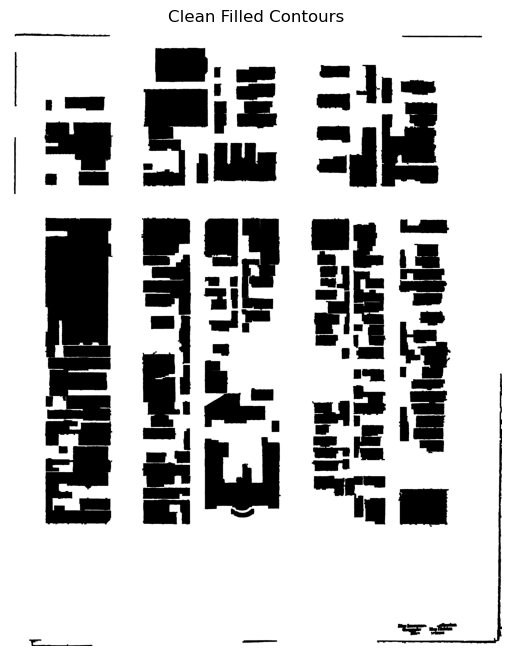

In [10]:
def remove_small_writings(image_path):
    """
    Remove small writings or strokes from a black and white map.
    
    Parameters:
    image_path (str): The path to the image file (black and white map)
    
    Returns:
    str: Path to the saved image with small writings removed
    """
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded correctly
    if image is None:
        raise ValueError("Image not found or unable to load.")

    # Apply binary thresholding
    _, binary_image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)

    # Define kernel for morphological operations
    kernel = np.ones((10,10), np.uint8)

    # Perform morphological opening to remove small white regions (small writings)
    opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    # Save the result image
    result_path = "smoothed_map.png"
    cv2.imwrite(result_path, opened_image)
    
    return result_path

def process_image_and_save(input_image_path, cleaned_image_path='cleaned_image.png', filled_contours_path='contours_filled1.png'):
    """
    Process a black and white map image to clean small writings, detect and draw contours, 
    and save the cleaned image and the image with filled contours.

    Parameters:
    - input_image_path (str): Path to the input black and white map image file.
    - cleaned_image_path (str, optional): Path to save the cleaned image with removed small writings.
      Default is 'cleaned_image.png'.
    - filled_contours_path (str, optional): Path to save the image with filled contours.
      Default is 'contours_filled1.png'.

    Returns:
    None

    This function reads the input image, removes small writings or strokes, applies Gaussian blur 
    and adaptive thresholding to prepare the image for contour detection. It detects contours,
    filters them based on area, and draws clean contours on a copy of the original image. 
    The cleaned image and the image with filled contours are saved at the specified paths.
    The final filled contours image is also displayed using matplotlib.pyplot.

    Note:
    - Adjust the thresholding parameters, morphological operations, and contour filtering
      (like min_contour_area) as needed based on specific image characteristics.

    Example usage:
    >>> input_image_path = 'path_to_your_input_image.png'
    >>> process_image_and_save(input_image_path)

    This will process the input image, save 'cleaned_image.png' and 'contours_filled1.png',
    and display the filled contours image using plt.imshow().
    """
    # Remove small writings first
    smoothed_map_path = remove_small_writings(input_image_path)
    
    # Load the smoothed image
    image = cv2.imread(smoothed_map_path)
    
    # Convert to grayscale and apply Gaussian blur
    gray1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray1, (9, 9), 0)
    
    # Apply adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    # Perform morphological operations to clean the image
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=5)
    
    # Find contours
    contours, _ = cv2.findContours(sure_bg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a copy of the original image
    clean_image = image.copy()
    
    # Filter contours based on area and draw clean contours on the image
    min_contour_area = 8000  # Adjust this threshold as needed
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    cv2.drawContours(clean_image, filtered_contours, -1, (0, 255, 0), 2)
    
    # Save the cleaned image
    cv2.imwrite(cleaned_image_path, clean_image)
    
    # Create a white background image
    white_bg = np.ones_like(image) * 255  # Create a white image
    
    # Draw contours filled with black on the white background
    cv2.drawContours(white_bg, filtered_contours, -1, (0, 0, 0), cv2.FILLED)
    
    # Save the filled contours image
    cv2.imwrite(filled_contours_path, white_bg)

    #Displaying the filled contours image
    filled_contours_image = cv2.imread(filled_contours_path)
    filled_contours_image_rgb = cv2.cvtColor(filled_contours_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(filled_contours_image_rgb)
    plt.title('Clean Filled Contours')
    plt.axis('off')
    plt.show()


# Example usage:
input_image_path = 'combined_black_regions_cv2_1.png' 
process_image_and_save(input_image_path)